# Imports 

In [43]:
import cv2
from matplotlib import pyplot
import numpy as np
from numpy import matlib
import re
import operator
from cmath import *
import time

# Definitions

In [44]:
def shift(register, feedback, output):
    
    # calculate output
    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]
        
    # modulo 2 add feedback
    fb = sum([register[i-1] for i in feedback]) % 2
    
    # shift to the right
    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]
        
    # put feedback in position 1
    register[0] = fb
    
    return out

In [45]:
def PRN(sv):
    
    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here
    
    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table
        
        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code
    return ca

In [46]:
def int2binarr(intnum, sizeup = False, sz = 8):
    binbin = bin(intnum)
    binstrip = re.sub('0b', '', str(binbin))
    if sizeup and (len(binstrip) !=sz) :
        binstrip = '0'*(sz-len(binstrip)) + binstrip
    binbin_ = re.sub('0', '0 ', binstrip)
    binbin_ = re.sub('1', '1 ', binbin_)
    binarr = np.fromstring(binbin_, dtype=int, sep=' ')
    return binarr

In [47]:
def sigplot(num_samples, complex_signal, viewsize):
    pyplot.plot(np.arange(0, num_samples), complex_signal.real)
    pyplot.plot(np.arange(0, num_samples), complex_signal.imag)
    pyplot.xlim(viewsize)
    pyplot.show()

In [48]:
# Knuth-Morris-Pratt string matching
# David Eppstein, UC Irvine, 1 Mar 2002

from __future__ import generators

def KnuthMorrisPratt(text, pattern):

    '''Yields all starting positions of copies of the pattern in the text.
Calling conventions are similar to string.find, but its arguments can be
lists or iterators, not just strings, it returns all matches, not just
the first one, and it does not need the whole text in memory at once.
Whenever it yields, it will have read the text exactly up to and including
the match that caused the yield.'''

    # allow indexing into pattern and protect against change during yield
    pattern = list(pattern)

    # build table of shift amounts
    shifts = [1] * (len(pattern) + 1)
    shift = 1
    for pos in range(len(pattern)):
        while shift <= pos and pattern[pos] != pattern[pos-shift]:
            shift += shifts[pos-shift]
        shifts[pos+1] = shift

    # do the actual search
    startPos = 0
    matchLen = 0
    for c in text:
        while matchLen == len(pattern) or \
              matchLen >= 0 and pattern[matchLen] != c:
            startPos += shifts[matchLen]
            matchLen -= shifts[matchLen]
        matchLen += 1
        if matchLen == len(pattern):
            yield startPos

In [49]:
def binarr2int(arr):
    bitlen = int(''.join(map(str, arr)), 2)
    return bitlen

In [50]:
def searchhf(arr, patt):
    identified = []
    for s in KnuthMorrisPratt(arr, patt): 
        identified.append(s)
    
    return identified

In [51]:
def findbitstring(sigsig, seqlen_from_head, seqlen_from_foot, datafoot):
    #seqlen_from_head = [] #instantiate data lengths
    #seqlen_from_foot = []
    #datafoot = []
    for s in sigsig.arraystart:
        start = s+len(sigsig.head)
        stop = s+len(sigsig.head)+sigsig.seqlen

        head = sigsig.demodded[start:stop]
        headlength = binarr2int(head)
        seqlen_from_head.append(headlength)

        foot = sigsig.demodded[(stop+headlength):(stop+sigsig.seqlen+headlength)]
        footlength = binarr2int(foot)
        seqlen_from_foot.append(footlength)

        c = sigsig.demodded[stop+sigsig.seqlen+headlength:stop+sigsig.seqlen+headlength+len(sigsig.foot)]
        footer = binarr2int(c)
        datafoot.append(footer)

In [52]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

# Create Signal Class

In [53]:
class Signal:
        '''Initialize signal class specifying a header and footer bit sequence
        in Int format and a samples per symbol value. Default for samples per
        symbol is 1'''
        
        def __init__(self, head, foot, sps = 1):
            self.foot = int2binarr(foot).astype(np.int8)
            self.head = int2binarr(head).astype(np.int8)
            self.sps = sps
        
        '''load in a specified image where imageloc is the path to an image file'''
        def imageload(self, imageloc):
            self.image = cv2.imread(imageloc)
        
        '''flatten the image from a AxBxC to an ABCx1 1-D array'''
        def flattendata(self):
            self.flattened = (self.image).flatten()
        
        '''transform values in the 1-D array from decimal values to 8 bit arrays of 1s and 0s'''
        def bitbybit(self):
            breakdown = list(map(lambda x: int2binarr(x, True),self.flattened))
            self.bitstream = np.concatenate(breakdown).ravel()            
        
        def prncode(self, codenum):
            self.prn = PRN(codenum)
        
        def addstartstop(self):
            sampledsig_=matlib.repmat(self.bitstream, self.sps, 1)
            self.seqlen=10
            dfv = len(self.prn) - (len(self.head) + len(self.foot) + 2*self.seqlen)
            nume = len(self.bitstream)*self.sps
            self.rpts = int(np.ceil(nume/dfv))
            self.sampledsig = np.reshape(sampledsig_, sampledsig_.size, 1)
            reshp = list(self.sampledsig)
            aa = chunks(reshp, dfv)
            header = list(self.head)
            footer = list(self.foot)
            a = []
            for i in range(self.rpts):
                data = next(aa)
                blen = list(int2binarr(len(data), True, self.seqlen))
                a.append(header + blen + data + blen + footer)
            self.fullsignal = np.concatenate([np.array(i) for i in a])
        
        
        def prnexpand(self):
            self.fullcode = matlib.repmat(self.prn, 1, self.rpts)
            
            
        def sigpad(self):
            extrapad = (0, self.fullcode.size - self.fullsignal.size)
            self.padded = np.pad(self.fullsignal, extrapad , 'constant', constant_values=(0,0))
            
        def modulate(self, Fc):
            freq = eval(Fc)
            T = 1/freq
            numsamp = len(self.prn)
            t = np.arange(0, self.rpts*numsamp)
            freqspec = 2*pi*freq*t*T/numsamp
            self.modded = np.fromiter(map(cos, freqspec + self.padded*pi), dtype=np.complex64)
            self.carrierI = np.fromiter(map(cos, freqspec), dtype=np.complex64)
            self.carrierQ = np.fromiter(map(sin, freqspec), dtype=np.complex64)
            self.carrierI2 = np.square(self.carrierI)
            self.carrierQ2 = 2*self.carrierI*self.carrierQ
            
        def shiftphase(self, rads):
            phase = np.complex(cos(rads), sin(rads))
            self.shiftedphase = self.modded*phase
            self.pshift = rads
            self.pshift_complex = phase
        
        def solvepshift(self):
            overairp2 = pow(self.shiftedphase, 2)
            absoverairp2 = pow(abs(self.shiftedphase),2)
            phase_correction = np.sqrt(absoverairp2/overairp2)
            self.pcorrected = phase_correction*self.shiftedphase
        
        def demodulate(self):
            #self.modded switched with pcorrected
            nume = -self.pcorrected*(self.carrierI.real +  1j*self.carrierQ.real)
            deno = (1+ (self.carrierI2.real + 1j* self.carrierQ2.real))
            demoddedsig = (0.5 + nume/deno)
            self.demodded = np.round(demoddedsig.real).astype(np.uint8)
            
        def getstartstop(self):
            self.arraystart = searchhf(self.demodded, self.head)
            self.arraystop = searchhf(self.demodded, self.foot)
                
        def getvalidpairs(self):
            self.head_datalength = []
            self.foot_datalength = []
            self.pfooter = []
            findbitstring(self, self.head_datalength, self.foot_datalength, self.pfooter)
            self.valpairs = []
            for s, a, b, c in zip(self.pfooter, self.head_datalength, self.foot_datalength, self.arraystart):
                if (s == binarr2int(self.foot)) & (a == b):
                    self.valpairs.append((c+len(self.head)+self.seqlen, c + a + len(self.head) + self.seqlen))
        def cutwithpairs(self):
            bb = list(self.demodded)
            reconstructedsignal = []
            for a, b in self.valpairs:
                reconstructedsignal.append(bb[a:b])
            self.reconstructedarray = np.concatenate([np.array(i) for i in reconstructedsignal])
        
        def reshapesps(self):
            self.recoveredsps2 = np.reshape(self.reconstructedarray, (self.sps, int(self.reconstructedarray.size/self.sps)), 1)
            self.recoveredsps = self.recoveredsps2[0, :]
            self.reshapedsig = np.reshape(self.recoveredsps, (self.image.size, 8))
            
        def reconimage(self):
            a = []
            for i in range(len(self.reshapedsig)):
                charr = binarr2int(self.reshapedsig[i, :])
                a.append(charr)
            self.imagerecon = np.reshape(np.array(a), self.image.shape).astype(np.uint8)
            
        def reshapeimage(self):
            b = self.imagerecon[:, :, 0]
            g = self.imagerecon[:, :, 1]
            r = self.imagerecon[:, :, 2]
            self.imagereord = np.dstack((r, g, b))

# Constants

In [54]:
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

# Generating Signal

In [55]:
sig1 = Signal(123,143, 1) #signal 1 is given a header sequence of 123 and a footer sequence of 143

###### Load an image and flatten the image to 1-D for conenvience & change to binary

In [56]:
sig1.imageload('Images/Image1.png')

In [57]:
sig1.flattendata()

In [58]:
sig1.bitbybit()

#### Generate a CA code to use (all lengths are 1023), sequence is expanded

In [59]:
sig1.prncode(24) #specify sequence 24 to be used for coding the 

#### Add header and footer to packetize data

In [60]:
sig1.addstartstop()

#### Expand PRN

In [61]:
sig1.prnexpand()

#### Pad the full signal with header & footer to match size of repeated CA sequence

In [62]:
sig1.sigpad()

#### Modulate Bits onto specified carrier waveform

In [63]:
sig1.modulate('915e6')

#### Phase shift the BPSK Signal

In [64]:
sig1.shiftphase(pi/3)

In [65]:
sig1.solvepshift()

#### Demodulate the Corrected BPSK signal

In [66]:
sig1.demodulate()

#### Identify valid header and footer pairs

In [67]:
sig1.getstartstop()

In [68]:
sig1.getvalidpairs()

#### Check if phase correction was correct (valid pairs shouldn't be empty)

In [69]:
if not len(sig1.valpairs):
    sig1.demodded = abs(sig1.demodded-1)
    sig1.getstartstop()
    sig1.getvalidpairs()
    sig1.greaterthanpi = True

# Reconstruct

In [70]:
sig1.cutwithpairs()

In [71]:
sig1.reshapesps()

In [72]:
sig1.reconimage()

In [73]:
sig1.reshapeimage()

(-0.5, 224.5, 224.5, -0.5)

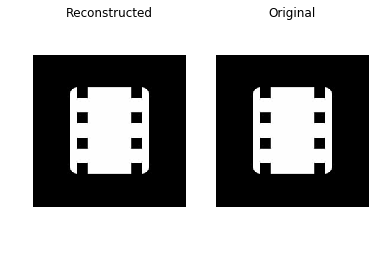

In [94]:
fig, axs = pyplot.subplots(1, 2)
columns = 2
rows = 1
axs[0].axis('off')
axs[1].axis('off')

fig.add_subplot(1,2,1)
pyplot.imshow(sig1.imagereord)
pyplot.axis('off')
axs[0].set_title('Reconstructed')

fig.add_subplot(1,2,2)
pyplot.imshow(cv2.cvtColor(sig1.image, cv2.COLOR_BGR2RGB))
axs[1].set_title('Original')
pyplot.axis('off')